In [1]:
import sionna.rt
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sionna.rt import load_scene, AntennaArray, PlanarArray, Transmitter, Receiver, Camera,\
                      PathSolver, RadioMapSolver, subcarrier_frequencies

print("Sionna version:", sionna.rt.__version__)

Sionna version: 1.0.2


In [2]:
# check gpu used
import tensorflow as tf
print("tf version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("GPU:", tf.config.list_physical_devices('GPU'))


2025-06-10 13:05:43.234741: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749560743.263417  211309 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749560743.272731  211309 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749560743.295402  211309 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749560743.295439  211309 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749560743.295441  211309 computation_placer.cc:177] computation placer alr

tf version: 2.19.0
Num GPUs Available:  2
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [3]:
# Load scene
scene = load_scene(r"/home/user/6GTandem_RT_server/6G_Tandem_kantoorruimte_v10/office_space.xml") 

2025-06-10 13:05:46 WARN wrk0 [HDRFilm] Monochrome mode enabled, setting film output pixel format to 'luminance' (was rgb).

In [4]:
# open interactive window to preview the scene 
scene.preview();


In [5]:

# check which materials are available in the scene
for name, obj in scene.objects.items():
    print(f'{name:<15}{obj.radio_material.name}')

no-name-1      ituf_glass
no-name-2      ituf_metal
Ceiling_Detail ituf_polystyrene
no-name-3      ituf_concrete
no-name-4      ituf_mdf


In [6]:
# adjust radio properties of the materials
# define callbacks to set conductivity and relative permittivity based on ITUF materials from hexa-x
def ituf_glass_callback(f_hz):
  f_ghz = f_hz / 1e9
  relative_permittivity = 6.2
  c, d = 0.005, 1.2
  conductivity = c*np.power(f_ghz, d)
  return (relative_permittivity, conductivity)

def ituf_concrete_callback(f_hz):
  f_ghz = f_hz / 1e9
  relative_permittivity = 1.9
  c, d = 0.002, 1.3
  conductivity = c*np.power(f_ghz, d)
  return (relative_permittivity, conductivity)

def ituf_metal_callback(f_hz):
  f_ghz = f_hz / 1e9
  relative_permittivity = 1.0  
  c, d = 10**7, 0.0
  conductivity = c*np.power(f_ghz, d)
  return (relative_permittivity, conductivity)

def ituf_polystyrene_callback(f_hz):
  f_ghz = f_hz / 1e9
  relative_permittivity = 1.05 #eta_r
  c, d = 0.000008, 1.1
  conductivity = c*np.power(f_ghz, d)
  return (relative_permittivity, conductivity)

def ituf_mdf_callback(f_hz):
  f_ghz = f_hz / 1e9
  relative_permittivity = 2.0 #eta_r
  c, d = 0.005, 1.0
  conductivity = c*np.power(f_ghz, d)
  return (relative_permittivity, conductivity)

# add callbacks to the materials
# polystyrene
ceiling_object = scene.get("Ceiling_Detail")
ceiling_object.radio_material.frequency_update_callback = ituf_polystyrene_callback
print(ceiling_object.radio_material.name)
print(ceiling_object.radio_material.frequency_update_callback)

# no-name-1 => ituf_glass
glass_objects = scene.get("no-name-1")
glass_objects.radio_material.frequency_update_callback = ituf_glass_callback
print(glass_objects.radio_material.name)
print(glass_objects.radio_material.frequency_update_callback)

# no-name-2 => ituf_concrete
concrete_objects = scene.get("no-name-2")
concrete_objects.radio_material.frequency_update_callback = ituf_concrete_callback
print(concrete_objects.radio_material.name)
print(concrete_objects.radio_material.frequency_update_callback)

# no-name-3 => ituf_metal
metal_objects = scene.get("no-name-3")
metal_objects.radio_material.frequency_update_callback = ituf_metal_callback
print(metal_objects.radio_material.name)
print(metal_objects.radio_material.frequency_update_callback)

# no-name-4 => ituf_mdf
metal_mdf = scene.get("no-name-4")
metal_mdf.radio_material.frequency_update_callback = ituf_mdf_callback
print(metal_mdf.radio_material.name)
print(metal_mdf.radio_material.frequency_update_callback)


ituf_polystyrene
<function ituf_polystyrene_callback at 0x77f2e7c80f40>
ituf_glass
<function ituf_glass_callback at 0x77f44a75f240>
ituf_metal
<function ituf_concrete_callback at 0x77f2e7c80cc0>
ituf_concrete
<function ituf_metal_callback at 0x77f2e7c80d60>
ituf_mdf
<function ituf_mdf_callback at 0x77f2e7c809a0>


In [7]:
# check conductivity and relative permittivity at different frequencies
# loop through material names and print them
sub_GHz = 3.5e9
sub_THz = 170e9
# todo set values at 170 GHZ
for key, value in scene.objects.items():
    print(f'---------------{key=}----------------')
    # Print name of assigned radio material for different frequenies
    for f in [sub_GHz, sub_THz]: # Print for differrent frequencies
        scene.frequency = f
        value.radio_material.frequency_update() # update the frequency of the objects
        print(f"\nRadioMaterial: {value.radio_material.name} @ {scene.frequency/1e9}GHz")
        print("Conductivity:", value.radio_material.conductivity.numpy())
        print("Relative permittivity:", value.radio_material.relative_permittivity.numpy())
        print("Scattering coefficient:", value.radio_material.scattering_coefficient.numpy())
        print("XPD coefficient:", value.radio_material.xpd_coefficient.numpy())




---------------key='no-name-1'----------------

RadioMaterial: ituf_glass @ [3.5]GHz
Conductivity: [0.02248287]
Relative permittivity: [6.2]
Scattering coefficient: [0.]
XPD coefficient: [0.]

RadioMaterial: ituf_glass @ [170]GHz
Conductivity: [2.3741536]
Relative permittivity: [6.2]
Scattering coefficient: [0.]
XPD coefficient: [0.]
---------------key='no-name-2'----------------

RadioMaterial: ituf_metal @ [3.5]GHz
Conductivity: [0.01019339]
Relative permittivity: [1.9]
Scattering coefficient: [0.]
XPD coefficient: [0.]

RadioMaterial: ituf_metal @ [170]GHz
Conductivity: [1.5871336]
Relative permittivity: [1.9]
Scattering coefficient: [0.]
XPD coefficient: [0.]
---------------key='Ceiling_Detail'----------------

RadioMaterial: ituf_polystyrene @ [3.5]GHz
Conductivity: [3.1736927e-05]
Relative permittivity: [1.05]
Scattering coefficient: [0.]
XPD coefficient: [0.]

RadioMaterial: ituf_polystyrene @ [170]GHz
Conductivity: [0.00227292]
Relative permittivity: [1.05]
Scattering coefficie

In [8]:
# add sub-THz stripes
# todo add more then one tx

# Configure antenna array for all transmitters
#normalized_array_pos = np.array([[0, 0, 0], [0, 0.5, 0], [0, 1, 0], [0, 1.5, 0],
#                                [0.5, 0, 0], [0.5, 0.5, 0], [0.5, 1, 0], [0.5, 1.5, 0],
#                                [1.0, 0, 0], [1.0, 0.5, 0], [1.0, 1, 0], [1.0, 1.5, 0],
#                                [1.5, 0, 0], [1.5, 0.5, 0], [1.5, 1, 0], [1.5, 1.5, 0]]) # positions in meters

# pattern = sionna.rt.antenna_pattern.Dipole() # antenna pattern
# scene.tx_array = AntennaArray( , normalized_positions=normalized_array_pos)
# # todo check which pattern

# todo change because this is in y-z plane
scene.tx_array = PlanarArray(num_rows=4,
                            num_cols=4,
                            vertical_spacing=0.5,
                            horizontal_spacing=0.5,
                            pattern="iso",
                            polarization="cross")

# Configure antenna array for all receivers
scene.rx_array = PlanarArray(num_rows=4,
                             num_cols=4,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="iso",
                             polarization="cross")

# Create sub-THz stripes
stripe_start_pos = [2, 2.5, 3.5]
N_RUs = 2 #40 # todo adjust to size of the room (along y axis)
N_stripes = 1 #10 # todo adjust to size of the room (alang x axis)
space_between_RUs = 0.5 # in meters
space_between_stripses = 0.5 # in meters
for stripe_idx in range(N_stripes):
    for RU_idx in range(N_RUs):
        # compute RU position
        tx_pos = [stripe_start_pos[0] + stripe_idx * space_between_stripses,
                  stripe_start_pos[1] + RU_idx * space_between_RUs,
                  stripe_start_pos[2]]
        
        tx = Transmitter(name=f"tx_stripe_{stripe_idx}_RU_{RU_idx}",
                        position=tx_pos,
                        display_radius=0.2)

        # Add RU transmitter instance to scene
        scene.add(tx)

        # Point the transmitter downwards
        tx.look_at([tx_pos[0], tx_pos[1], 0]) # Transmitter points downwards

# Create a receiver
rx_pos = [7, 10, 1]
rx = Receiver(name="rx",
              position=rx_pos,
              display_radius=1)

# Add receiver instance to scene
scene.add(rx)

tx.look_at([tx_pos[0], tx_pos[1], 0]) # Transmitter points downwards



In [9]:
scene.preview();


In [10]:
scene.frequency = 170e9 # Set frequency to 170 GHz
# implicityly updates radio material properties

# Instantiate a path solver
# The same path solver can be used with multiple scenes
p_solver  = PathSolver()

# Compute propagation paths
paths = p_solver(scene=scene,
                 max_depth=5,
                 los=True,
                 specular_reflection=True,
                 diffuse_reflection=False,
                 refraction=True,
                 synthetic_array=False,
                 seed=41)

jit_flush_malloc_cache(): Dr.Jit exhausted the available memory and had to flush its allocation cache to free up additional memory. This is an expensive operation and will have a negative effect on performance. You may want to change your computation so that it uses less memory. This warning will only be displayed once.


In [11]:
scene.preview(paths=paths, clip_at=20);

Shape of taps:  (1, 32, 2, 32, 1, 407)


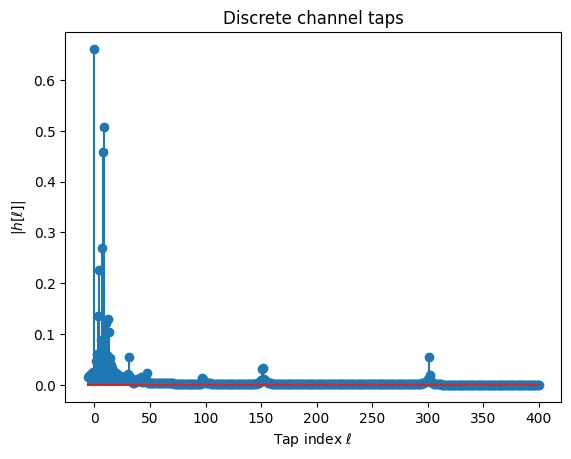

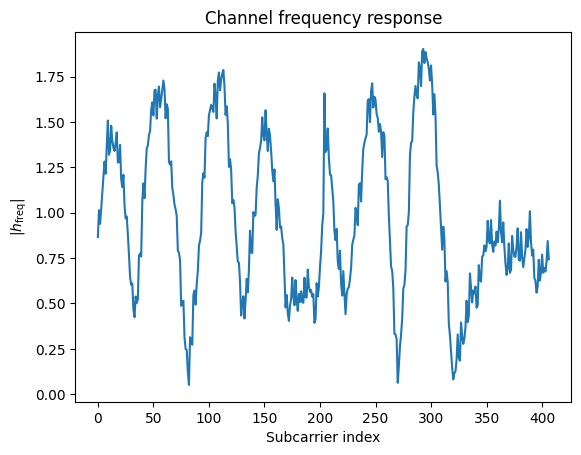

In [12]:
taps = paths.taps(bandwidth=1e9, # Bandwidth to which the channel is low-pass filtered 100MHé
                  l_min=-6,        # Smallest time lag
                  l_max=400,       # Largest time lag
                  sampling_frequency=None, # Sampling at Nyquist rate, i.e., 1/bandwidth
                  normalize=True,  # Normalize energy
                  normalize_delays=True,
                  out_type="numpy")
print("Shape of taps: ", taps.shape)

plt.figure()
plt.stem(np.arange(-6, 401), np.abs(taps)[0,0,0,0,0]);
plt.xlabel(r"Tap index $\ell$");
plt.ylabel(r"|$h[\ell]|$");
plt.title("Discrete channel taps");

# take fft to see frequency response
taps_fft = np.fft.fft(taps, axis=-1)

# Plot absolute value
plt.figure()
plt.plot(np.abs(taps_fft)[0,0,0,0,0,:]);
plt.xlabel("Subcarrier index");
plt.ylabel(r"|$h_\text{freq}$|");
plt.title("Channel frequency response");


bw = 0.98304 GHz
Shape of h_freq:  (1, 32, 2, 32, 1, 32768)
taps_check shape: (32768,)


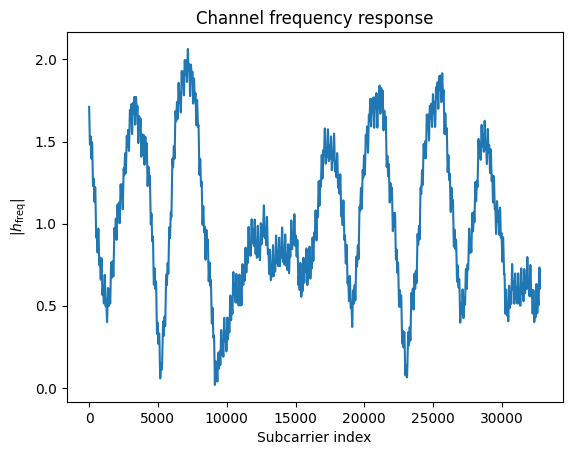

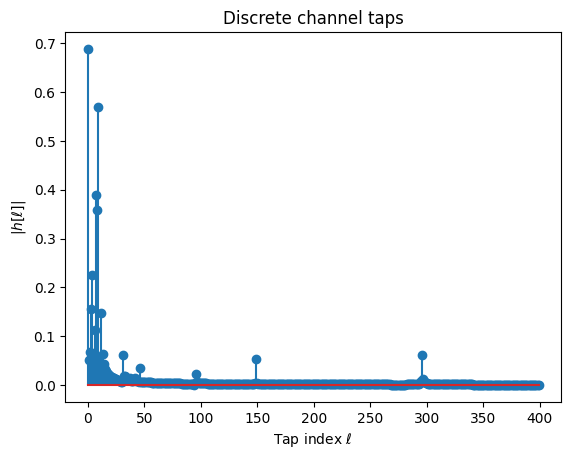

In [13]:
# check if we get frequency response and take ifft if we get the same thing!

# OFDM system parameters
num_subcarriers = 2**15 #1024
subcarrier_spacing=30e3
bw = num_subcarriers * subcarrier_spacing 
print(f'bw = {bw/1e9} GHz')

# Compute frequencies of subcarriers relative to the carrier frequency
frequencies = subcarrier_frequencies(num_subcarriers, subcarrier_spacing)

# Compute channel frequency response
h_freq = paths.cfr(frequencies=frequencies,
                   normalize=True, # Normalize energy
                   normalize_delays=True,
                   out_type="numpy")

# Shape: [num_rx, num_rx_ant, num_tx, num_tx_ant, num_time_steps, num_subcarriers]
print("Shape of h_freq: ", h_freq.shape)

# Plot absolute value
plt.figure()
plt.plot(np.abs(h_freq)[0,0,0,0,0,:]);
plt.xlabel("Subcarrier index");
plt.ylabel(r"|$h_\text{freq}$|");
plt.title("Channel frequency response");

taps_check = np.fft.ifft(h_freq[0,0,0,0,0,:], axis=-1) # Inverse FFT to get taps
print(f'taps_check shape: {taps_check.shape}')
plt.figure()
l = 400
plt.stem(np.arange(l), np.abs(taps_check[0:l]));
plt.xlabel(r"Tap index $\ell$");
plt.ylabel(r"|$h[\ell]|$");
plt.title("Discrete channel taps");